# VQE 
## 1. State preparation circuit
Convert |000000> state to an actual state |$\phi(\theta)$> with an arbitary input parameters set $\theta$

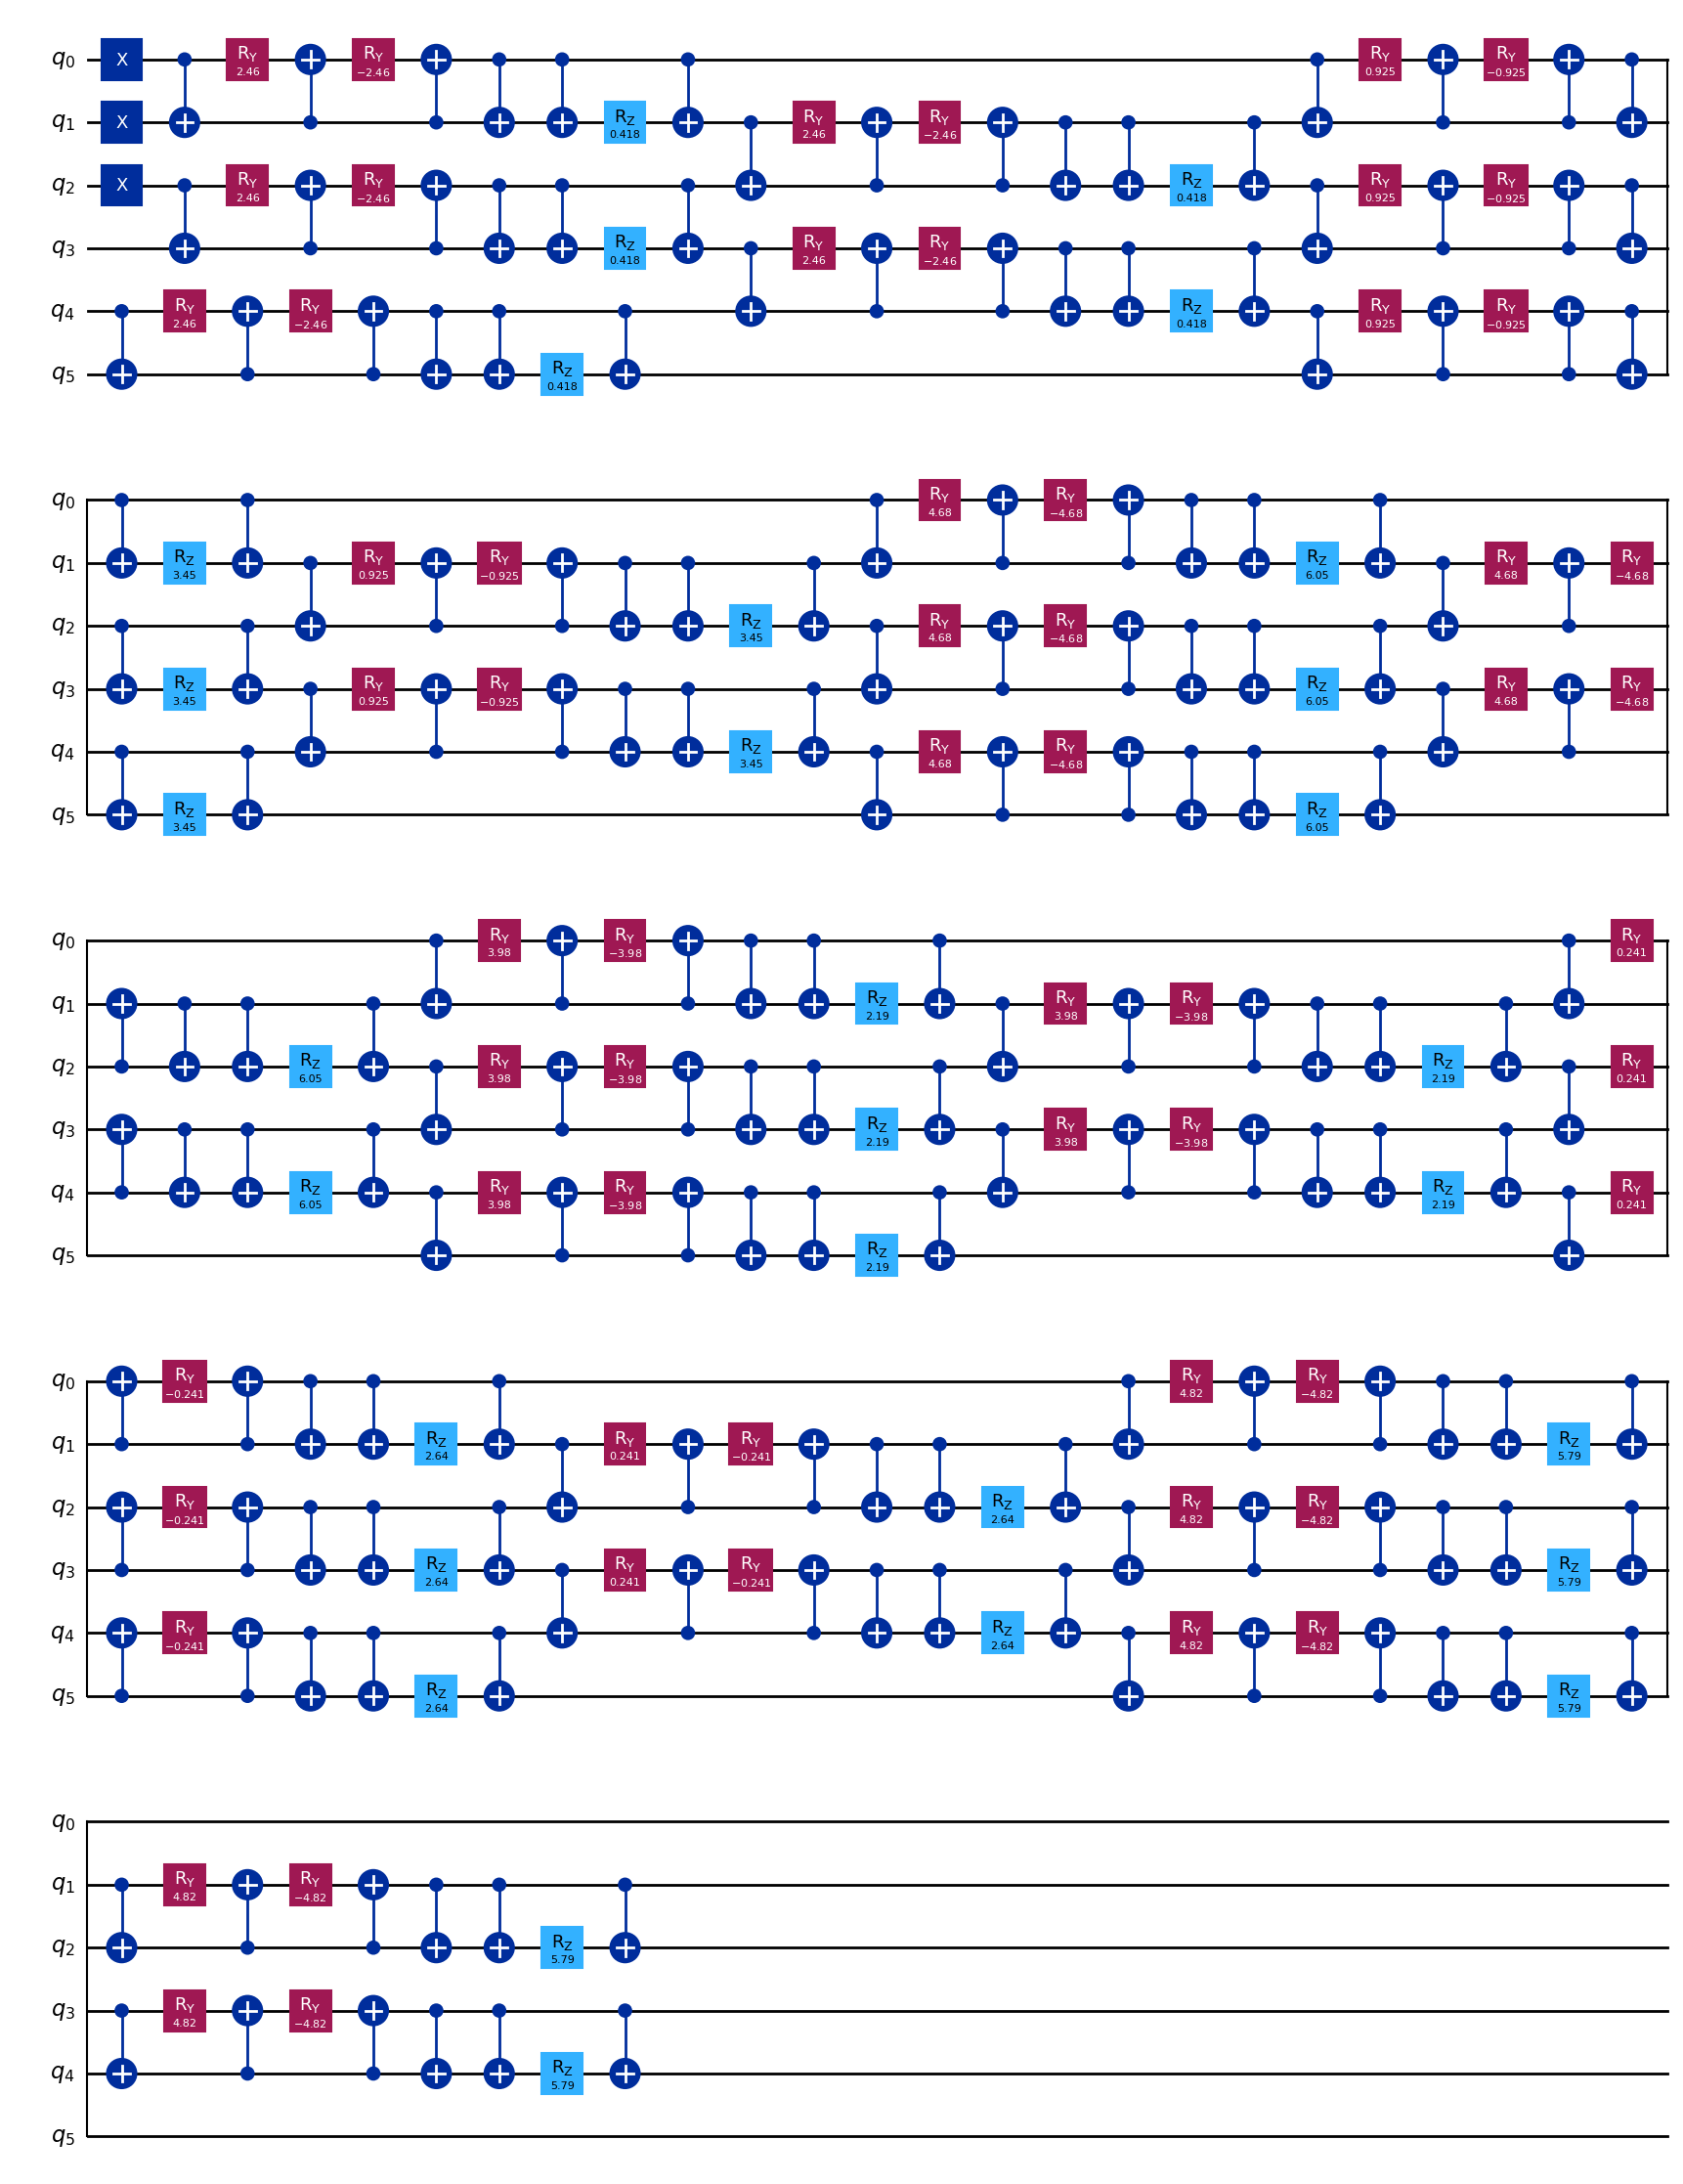

In [42]:
# Define and verify ansatz
import math, random
from typing import Callable, List, Tuple, Optional
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
import matplotlib as mpl
import numpy as np



def _build_hf_init(qc, n_qubits: int, n_particles: int):
    # Initialize Hatric-Fork State |000000> -> |111000>
    try:
        i = 0
        while i < n_particles:
            qc.x(i); i += 1
        return qc
    except Exception as e:
        raise RuntimeError(f"HF init build failed: {e}")

def _givens(qc, i: int, j: int, theta: float):
    # Number-conserving SU(2) mixer on modes (i,j).
    # Acts as: |01> -> cos(theta/2)|01> + sin(theta/2)|10>, etc.
    try:
        qc.cx(i, j)
        qc.ry(0.5*theta, i)
        qc.cx(j, i)
        qc.ry(-0.5*theta, i)
        qc.cx(j, i)
        qc.cx(i, j)
    except Exception as e:
        raise RuntimeError(f"Givens({i},{j}) failed: {e}")

def _pair_phase(qc, i: int, j: int, phi: float):
    # Diagonal entangler ~ exp(i*phi * n_i n_j) up to one-body phases.
    try:
        qc.cx(i, j)
        qc.rz(phi, j)
        qc.cx(i, j)
    except Exception as e:
        raise RuntimeError(f"PairPhase({i},{j}) failed: {e}")

def _layer(qc, beta: float, gamma: float, pairs_mix: List[Tuple[int,int]], pairs_zz: List[Tuple[int,int]]):
    # Mix on all chosen pairs with the SAME beta (low-parameter), then ZZ with SAME gamma.
    try:
        k = 0
        while k < len(pairs_mix):
            i, j = pairs_mix[k]
            _givens(qc, i, j, beta)   # beta maps to rotation angle θ
            k = k + 1
        k = 0
        while k < len(pairs_zz):
            i, j = pairs_zz[k]
            _pair_phase(qc, i, j, gamma)
            k = k + 1
    except Exception as e:
        raise RuntimeError(f"layer failed: {e}")

def ansatz(betas: List[float], gammas: List[float]):
    """
    Build p-layer ansatz with parameters betas, gammas (same length).
    Schedule: even-odd brickwork to cover all neighbors with linear depth.
    """
    try:
        from qiskit import QuantumCircuit
    except Exception as e:
        raise RuntimeError(f"Qiskit import failed: {e}")

    if not isinstance(betas, list) or not isinstance(gammas, list):
        raise ValueError("betas/gammas must be lists of floats")
    if len(betas) != len(gammas):
        raise ValueError("betas and gammas must have the same length")
    p = len(betas)
    if p < 1:
        raise ValueError("need at least one layer")

    try:
        qc = QuantumCircuit(6, name="NC-LP")
        _build_hf_init(qc, 6, 3)


        even_pairs = [(0,1), (2,3), (4,5)]
        odd_pairs  = [(1,2), (3,4)]

        L = 0
        while L < p:
            beta = float(betas[L])
            gamma = float(gammas[L])
            _layer(qc, beta,  gamma, even_pairs, even_pairs)  # use same set for mixing and ZZ
            _layer(qc, beta,  gamma, odd_pairs,  odd_pairs)
            L = L + 1
        return qc
    except Exception as e:
        raise RuntimeError(f"make_nc_lowparam_ansatz failed: {e}")

# ---- Tests ----

betas = list(np.random.rand(6)*4*np.pi)
gammas = list(np.random.rand(6)*2*np.pi)
qc = ansatz(betas,gammas)
qc.draw(output="mpl")

## 2. Hamiltonian
Take the given Hamiltonian and calculate its expectation value
### 2.1 Define Hamiltonian

In [68]:
import itertools
import numpy as np

# ==== パラメータ設定 ====
num_orbitals = 6
num_particles = 3
delta = 1.0   # 1体項の等間隔エネルギー
v = 0.3       # 2体相互作用（ペア＋単粒子遷移含む）
w3 = 0.2      # 3体相互作用

# ==== 基底生成 ====
def generate_basis(num_orbitals, num_particles):
    basis = []
    for bits in itertools.combinations(range(num_orbitals), num_particles):
        occ = np.zeros(num_orbitals, dtype=int)
        occ[list(bits)] = 1
        basis.append(tuple(occ))
    return basis

basis = generate_basis(num_orbitals, num_particles)
dim = len(basis)

# ==== 生成消滅演算の定義 ====
def apply_annihilate(state, i):
    state = list(state)
    if state[i] == 0:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 0
    return tuple(state), sign

def apply_create(state, i):
    state = list(state)
    if state[i] == 1:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 1
    return tuple(state), sign

def apply_cdag_c(state, i, j):
    """c_i† c_j"""
    s1, sign1 = apply_annihilate(state, j)
    if s1 is None:
        return None, 0
    s2, sign2 = apply_create(s1, i)
    if s2 is None:
        return None, 0
    return s2, sign1 * sign2

# ==== 1体ハミルトニアン ====
H1 = np.zeros((dim, dim))
for p, s in enumerate(basis):
    for i, occ in enumerate(s):
        if occ == 1:
            energy = delta * (i // 2)  # 各2縮退レベルごとに等間隔
            H1[p, p] += energy

# ==== 2体ハミルトニアン（改訂版）====
pairs = [(0, 1), (2, 3), (4, 5)]
H2 = np.zeros((dim, dim))

def find_pair_and_single(state):
    """3粒子状態から (pair_index, single_orbital) を特定"""
    for p_idx, (a, b) in enumerate(pairs):
        if state[a] == 1 and state[b] == 1:
            s = [i for i in range(len(state)) if state[i] == 1 and i not in (a, b)][0]
            return p_idx, s
    return None, None

# すべてのペア・単粒子遷移を許す
for i, bra in enumerate(basis):
    p_bra, s_bra = find_pair_and_single(bra)
    if p_bra is None:
        continue  # ペアがない状態は作用しない

    for j, ket in enumerate(basis):
        p_ket, s_ket = find_pair_and_single(ket)
        if p_ket is None:
            continue

        # ペアと単粒子の両方が遷移できる
        # 全結合を許して同一強度v
        H2[i, j] += v



# ==== 3体ハミルトニアン（変更なし）====
triplets = [(0,1,2), (1,2,3), (2,3,4), (3,4,5)]
H3 = np.zeros((dim, dim))

for T1 in triplets:
    for T2 in triplets:
        for i, s in enumerate(basis):
            if all(s[k] == 1 for k in T2):
                s_new = list(s)
                sign = 1
                # アニヒレート
                for k in reversed(T2):
                    s_new, sgn = apply_annihilate(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                # クリエイト
                for k in T1:
                    s_new, sgn = apply_create(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                s_new = tuple(s_new)
                if s_new in basis:
                    j = basis.index(s_new)
                    H3[i, j] += w3 * sign

# ==== 総ハミルトニアン ====
H = H1 + H2 + H3
H = (H + H.conj()) / 2  # Hermitian化

# ==== 結果表示 ====
np.set_printoptions(precision=2, suppress=True)
print("Hamiltonian matrix (dim={}):".format(dim))
print(H)

# ==== 固有値 ====
eigvals, eigvecs = np.linalg.eigh(H)
print("\nEigenvalues:")
print(np.round(eigvals, 4))

print("\nNonzero elements in H2:", np.count_nonzero(H2))

Hamiltonian matrix (dim=20):
[[1.5 0.3 0.3 0.3 0.3 0.  0.  0.  0.  0.3 0.5 0.  0.  0.  0.  0.3 0.5 0.3
  0.3 0.5]
 [0.3 1.3 0.3 0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.3 0.3 2.3 0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.3 0.3 0.3 2.3 0.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.3 0.3 0.3 0.3 2.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.3 0.3 0.3 0.3 0.3 0.  0.  0.  0.  4.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.5 0.3 0.3 0.3 0.3 0.  0.  0.  0.  0.3 2.5 0.  0.  0.  0.  0.3 0.5 0.3
  0.3 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

### 2.2 Pauli Expansion

In [79]:
import itertools
import numpy as np

# ==== 全基底（64次元） ====
all_basis = [tuple(int(x) for x in format(i, '06b')) for i in range(2**6)]

# ==== 3粒子空間の基底インデックスを求める ====
basis_index = [all_basis.index(b) for b in basis]

# ==== 20次元→64次元への埋め込み ====
H_full = np.zeros((64, 64), dtype=complex)
for i, bi in enumerate(basis_index):
    for j, bj in enumerate(basis_index):
        H_full[bi, bj] = H[i, j]

# ==== パウリ行列定義 ====
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
paulis = [I, X, Y, Z]
labels = ['I','X','Y','Z']

# ==== Pauli 展開 ====
coeffs = {}
for ops in itertools.product(range(4), repeat=6):
    P = paulis[ops[0]]
    for k in ops[1:]:
        P = np.kron(P, paulis[k])
    c = np.trace(P @ H_full) / 64
    if abs(c) > 1e-8:
        label = ''.join(labels[k] for k in ops)
        coeffs[label] = np.real_if_close(c)

# ==== 出力 ====
#print(f"\nNonzero Pauli terms ({len(coeffs)} terms):")
#for k, v in sorted(coeffs.items(), key=lambda x: -abs(x[1])):
#    print(f"{k:10s} : {v:.6f}")

# ==== Realign to little-endian for Qiskit =====
import itertools
import numpy as np

# ---------- 1) Expand H_full (BIG-ENDIAN) into BIG-ENDIAN Pauli dict ----------
def _pauli_1q(c):
    if c == 'I': return np.array([[1,0],[0,1]], complex)
    if c == 'X': return np.array([[0,1],[1,0]], complex)
    if c == 'Y': return np.array([[0,-1j],[1j,0]], complex)
    if c == 'Z': return np.array([[1,0],[0,-1]], complex)
    raise ValueError("bad Pauli char")

def _be_pauli_matrix(label: str):
    try:
        if not label or not isinstance(label, str):
            raise ValueError("empty label")
        P = _pauli_1q(label[0])
        i = 1
        while i < len(label):
            P = np.kron(P, _pauli_1q(label[i]))
            i += 1
        return P
    except Exception as e:
        raise RuntimeError(f"be_pauli_matrix failed: {e}")

def be_pauli_expand(H_full_big: np.ndarray, tol: float = 1e-12):
    try:
        if H_full_big.ndim != 2 or H_full_big.shape[0] != H_full_big.shape[1]:
            raise ValueError("H must be square")
        dim = H_full_big.shape[0]
        n = int(round(np.log2(dim)))
        if (1 << n) != dim:
            raise ValueError("size must be power of 2")
        coeffs = {}
        norm = float(1 << n)
        for ops in itertools.product(['I','X','Y','Z'], repeat=n):
            label = ''.join(ops)  # BIG-ENDIAN (leftmost = q_{n-1})
            P = _be_pauli_matrix(label)
            c = np.trace(P @ H_full_big) / norm
            cr = float(np.real(c))
            if abs(cr) > tol:
                coeffs[label] = cr
        return coeffs
    except Exception as e:
        raise RuntimeError(f"be_pauli_expand failed: {e}")

# ---------- 2) Convert BIG-ENDIAN dict -> Qiskit SparsePauliOp (little-endian labels) ----------
def be_dict_to_qiskit(coeffs_be: dict):
    try:
        from qiskit.quantum_info import SparsePauliOp
        labels_le = []
        coeffs_le = []
        for lbl_be, c in coeffs_be.items():
            labels_le.append(lbl_be[::-1])  # reverse to LITTLE-ENDIAN (rightmost = q0)
            coeffs_le.append(float(c))
        op = SparsePauliOp(labels_le, np.array(coeffs_le, dtype=float))
        # Merge duplicates / clean tiny coeffs
        return op.simplify(atol=0.0)
    except Exception as e:
        raise RuntimeError(f"be_dict_to_qiskit failed: {e}")

# ---------- 3) Verify: Operator(op) permuted to BIG-ENDIAN ≈ H_full_big ----------
def _bit_rev(x: int, n: int) -> int:
    y = 0; i = 0
    while i < n:
        y = (y << 1) | ((x >> i) & 1)
        i += 1
    return y

def verify_qiskit_matches_big(H_full_big: np.ndarray, hamiltonian_op) -> float:
    try:
        from qiskit.quantum_info import Operator
        M_le = Operator(hamiltonian_op).data
        dim = H_full_big.shape[0]
        n = int(round(np.log2(dim)))
        M_be = np.zeros_like(M_le)
        i = 0
        while i < dim:
            ii = _bit_rev(i, n)
            j = 0
            while j < dim:
                jj = _bit_rev(j, n)
                M_be[ii, jj] = M_le[i, j]
                j += 1
            i += 1
        return float(np.max(np.abs(H_full_big - M_be)))
    except Exception as e:
        raise RuntimeError(f"verify_qiskit_matches_big failed: {e}")

# ---------- 4) Rebuild & validate end-to-end ----------
def rebuild_hamiltonian_op_from_dense(H_full_big: np.ndarray, tol: float = 1e-12):
    try:
        coeffs_be = be_pauli_expand(H_full_big, tol=tol)
        h_op = be_dict_to_qiskit(coeffs_be)
        maxdiff = verify_qiskit_matches_big(H_full_big, h_op)
        return h_op, maxdiff
    except Exception as e:
        raise RuntimeError(f"rebuild_hamiltonian_op_from_dense failed: {e}")


hamiltonian_op, maxdiff = rebuild_hamiltonian_op_from_dense(H_full, tol=1e-12)
print("max |H_full - Pi^T Op Pi| =", maxdiff)  # expect ~1e-12

max |H_full - Pi^T Op Pi| = 1.7763568394002505e-15


### 2.3 Estimate Hamiltonian Expectation Value

In [80]:
import numpy as np
from typing import List, Optional



# ---------- Expectation with dense H_full ----------
def expval_dense(H_full: np.ndarray, psi_big: np.ndarray) -> complex:
    try:
        if H_full.ndim != 2 or H_full.shape[0] != H_full.shape[1]:
            raise ValueError("H_full must be a square matrix")
        if H_full.shape[0] != len(psi_big):
            raise ValueError("shape mismatch between H_full and psi")
        # Compute psi^† (H psi)
        Hv = H_full @ psi_big
        acc = 0.0 + 0.0j
        i = 0
        while i < len(psi_big):
            acc = acc + np.conjugate(psi_big[i]) * Hv[i]
            i = i + 1
        return acc
    except Exception as e:
        raise RuntimeError(f"expval_dense failed: {e}")

# ---------- Build state from ansatz ----------
def state_from_ansatz(make_fn, beta: List[float],gamma :List[float], n_qubits: int) -> np.ndarray:
    try:
        from qiskit.quantum_info import Statevector
    except Exception as e:
        raise RuntimeError(f"Qiskit not available: {e}")
    try:
        qc = make_fn(beta,gamma)  
        sv = Statevector.from_instruction(qc)
        return np.array(sv.data, dtype=complex)
    except Exception as e:
        raise RuntimeError(f"state_from_ansatz failed: {e}")

# ---------- Optional: expectation via SparsePauliOp ----------
def expval_sparsepauli(hamiltonian_op, make_fn, params: List[float]):
    try:
        from qiskit.quantum_info import Statevector, Operator
    except Exception as e:
        raise RuntimeError(f"Qiskit not available: {e}")
    try:
        beta = [float(params[k]) for k in range(6)]
        gamma = [float(params[k+6]) for k in range(6)]
        sv = Statevector.from_instruction(make_fn(beta,gamma))
        op = Operator(hamiltonian_op)
        val = sv.expectation_value(op)
        return np.real(complex(val))
    except Exception as e:
        raise RuntimeError(f"expval_sparsepauli failed: {e}")


In [81]:
# Compare expectation value of dense matrix and SparsePauliOp
psi = Statevector.from_instruction(qc)
psi = np.array(psi.data, dtype=complex)
params = betas + gammas

# Expectation with dense matrix
E_dense = expval_dense(H_full, psi)
print("E (dense) =", float(np.real(E_dense)))

# Expectation via SparsePauliOp 
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()
job = estimator.run([(qc, hamiltonian_op, )])
hamiltonion_result = job.result()
E_meas = hamiltonion_result[0].data.evs
print("E (SparsePauliOp) =", E_meas)
#E_sp = expval_sparsepauli(hamiltonian_op, ansatz, params)
#print("E (SparsePauliOp) =", float(np.real(E_sp)))


E (dense) = 2.8130138737087274
E (SparsePauliOp) = 3.4607916529429072


## 3. Optimization
### 3.1 Optimize agianst $\theta$ using COBYLA

In [82]:
def run_cobyla(hamiltonian_op, ansatz, beta0: list[float], gamma0: list[float]):
    import numpy as np
    from scipy.optimize import minimize

    # COBYLA callback logger (works with both signatures)
    import time
    from typing import List, Dict, Any, Callable, Tuple

    def make_cobyla_callback(energy_fn: Callable[[List[float]], float],
                             print_every: int = 0,
                             stop_below: float = None):
        state = {"t0": time.time(), "n": 0, "best_f": float("inf"), "best_x": None}
        history: List[Dict[str, Any]] = []
    
        def _canon(x: List[float]) -> List[float]:
            # optional angle wrapping for logging; adjust/remove if not needed
            import math
            p = len(x)//2
            y = []
            i = 0
            while i < p:
                y.append(((float(x[i]) + 2.0*math.pi) % (4.0*math.pi)) - 2.0*math.pi)  # β
                i += 1
            j = 0
            while j < p:
                y.append(((float(x[p+j]) + math.pi) % (2.0*math.pi)) - math.pi)        # γ
                j += 1
            return y
    
        def callback(*args, **kwargs):
            # New-style: callback(intermediate_result=OptimizeResult)
            ir = kwargs.get("intermediate_result", None)
            if ir is not None and hasattr(ir, "x"):
                x = list(ir.x)
                f = float(ir.fun) if getattr(ir, "fun", None) is not None else float(energy_fn(hamiltonian_op,ansatz,x))
            else:
                # Old-style: callback(xk)
                if len(args) >= 1:
                    x = list(args[0])
                    f = float(energy_fn(hamiltonian_op,ansatz,x))
                else:
                    return  # nothing to log
    
            state["n"] += 1
            if f < state["best_f"]:
                state["best_f"], state["best_x"] = f, list(x)
    
            rec = {
                "iter": state["n"],
                "time": float(time.time() - state["t0"]),
                "x": _canon(x),
                "f": f,
                "best_f": state["best_f"],
                "best_x": _canon(state["best_x"]) if state["best_x"] is not None else None,
            }
            history.append(rec)
            if print_every and (state["n"] % print_every == 0):
                print(f"[COBYLA] it={rec['iter']}, f={rec['f']:.6g}, best={rec['best_f']:.6g}")
    
            if (stop_below is not None) and (f <= float(stop_below)):
                raise StopIteration  # supported: stops the optimizer
    
        def get_history() -> List[Dict[str, Any]]:
            return list(history)
    
        def get_best() -> Tuple[List[float], float]:
            return (list(_canon(state["best_x"])) if state["best_x"] is not None else [], float(state["best_f"]))
    
        return callback, get_history, get_best


    cb, get_hist, get_best = make_cobyla_callback(expval_sparsepauli, print_every=100, stop_below=None)

    param0 = beta0 + gamma0
        
    res = minimize(
        fun = lambda z: expval_sparsepauli(hamiltonian_op,ansatz,list(z)),
        x0 = np.array(param0,dtype=float),
        method = "COBYLA",
        callback=cb
    )

    x_opt = [float(t) for t in res.x.tolist()]
    betas = [x_opt[k] for k in range(6)]
    gammas = [x_opt[k+6] for k in range(6)]
    hist = get_hist()

    return {"beta": betas, "gamma": gammas, "energy": float(res.fun),"history":hist}


beta0 = list(np.random.rand(6)*0.25+0.5)
gamma0 = list(np.random.rand(6)*0.25+0.5)
res = run_cobyla(hamiltonian_op,ansatz,beta0,gamma0)
print("beta = ", res["beta"])
print("gamma = ", res["gamma"])
print("energy = ", res["energy"])


[COBYLA] it=100, f=1.12047, best=1.12047
[COBYLA] it=200, f=1.10181, best=1.10181
[COBYLA] it=300, f=1.08914, best=1.08914
[COBYLA] it=400, f=1.07871, best=1.07871
[COBYLA] it=500, f=1.07608, best=1.07604
[COBYLA] it=600, f=1.07569, best=1.07569
[COBYLA] it=700, f=1.07552, best=1.07552
[COBYLA] it=800, f=1.07539, best=1.07539
[COBYLA] it=900, f=1.07531, best=1.0753
[COBYLA] it=1000, f=1.07524, best=1.07524
beta =  [0.4676611216351404, 0.4320815536018157, 0.9083281890169805, -0.5057324544300427, -0.4265906864403029, 0.6455931070872738]
gamma =  [1.1119549938742883, 0.8664056761905572, 1.3201320657184947, 0.16157452942815753, 1.5049150076512277, -0.028724482100969024]
energy =  1.0752380803796542


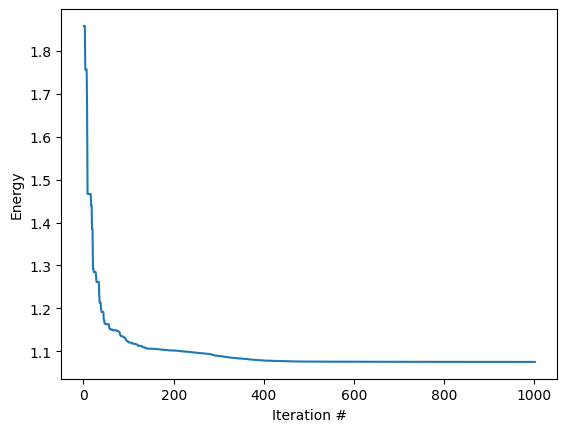

In [83]:
iteration = [i["iter"] for i in res["history"]]
best_f = [i["best_f"] for i in res["history"]]

plt.plot(iteration, best_f)
plt.xlabel("Iteration #")
plt.ylabel("Energy")
plt.show()

### 3.2 Forward the parameter to obtain corresponded eigenstate.

In [84]:
beta_res = res["beta"]
gamma_res = res["gamma"]

from qiskit.quantum_info import Statevector
qc_res = ansatz(beta_res,gamma_res)
sv = Statevector.from_instruction(qc_res)
state_res = np.array(sv.data,dtype=complex)

In [89]:
import math
import numpy as np

# ---------- bit ordering helpers (big-endian <-> little-endian) ----------
def _bit_reverse(idx: int, nbits: int) -> int:
    try:
        y = 0
        i = 0
        while i < nbits:
            y = (y << 1) | ((idx >> i) & 1)
            i = i + 1
        return y
    except Exception as e:
        raise RuntimeError(f"bit reverse failed: {e}")

def _bits_to_big_index(bits):
    # bits is a tuple/list like (b5,b4,b3,b2,b1,b0) in big-endian string order
    try:
        acc = 0
        i = 0
        n = len(bits)
        while i < n:
            acc = (acc << 1) | int(bits[i])
            i = i + 1
        return acc
    except Exception as e:
        raise RuntimeError(f"bits->index failed: {e}")

# ---------- project 6-qubit statevector to 20-dim N=3 basis ----------
def project_to_basis(psi_little: np.ndarray, basis) -> (np.ndarray, float):
    """
    psi_little: 1D complex array of length 64 from qiskit Statevector.data
    basis: list[tuple[int]] of length 20, each tuple of 6 bits in BIG-endian order (like your code)
    returns: (psi_N3 normalized (20,), weight_in_subspace)
    """
    try:
        if psi_little.ndim != 1:
            raise ValueError("psi must be 1D")
        nqubits = 6
        dim = 1 << nqubits
        if len(psi_little) != dim:
            raise ValueError("psi length must be 64 for 6 qubits")

        amps = []
        k = 0
        sumnorm = 0.0
        while k < len(basis):
            b = basis[k]
            ib = _bits_to_big_index(b)            # big-endian integer index
            jl = _bit_reverse(ib, nqubits)        # index in little-endian statevector
            a = complex(psi_lifestyle := psi_little[jl])  
            amps.append(a)
            sumnorm = sumnorm + (a.real*a.real + a.imag*a.imag)
            k = k + 1

        v = np.array(amps, dtype=complex)
        w = float(sumnorm)
        if w <= 0.0:
            raise ValueError("zero weight in N=3 subspace")
        # normalize within the subspace (should be ~1 already for number-conserving ansatz)
        norm = math.sqrt(w)
        v_norm = v / norm
        return v_norm, w
    except Exception as e:
        raise RuntimeError(f"project_to_basis failed: {e}")

# ---------- build ansatz statevector from optimized betas,gammas ----------
def state_from_ansatz(make_ansatz_fn, betas, gammas) -> np.ndarray:
    """Returns 64-dim little-endian statevector for 6-qubit circuit prepared by make_ansatz_fn(betas, gammas)."""
    try:
        from qiskit.quantum_info import Statevector
    except Exception as e:
        raise RuntimeError(f"Qiskit import failed: {e}")
    try:
        qc = make_ansatz_fn(list(betas), list(gammas))
        sv = Statevector.from_instruction(qc)
        return np.array(sv.data, dtype=complex)
    except Exception as e:
        raise RuntimeError(f"state_from_ansatz failed: {e}")

# ---------- exact ground state from 20×20 H  ----------
def ground_state_from_H(H: np.ndarray) -> (float, np.ndarray):
    """Return (E0, phi0) where phi0 is normalized eigenvector (length = H.shape[0])."""
    try:
        if H.ndim != 2 or H.shape[0] != H.shape[1]:
            throw = 1/0  # force except
        w, V = np.linalg.eigh(H)
        # V columns are eigenvectors; pick smallest eigenvalue
        m = int(np.argmin(w))
        phi = V[:, m]
        # ensure normalization (defensive)
        s = float(np.vdot(phi, phi).real)
        if s <= 0.0:
            raise ValueError("invalid eigenvector norm")
        phi = (1.0 / math.sqrt(s)) * phi
        return float(w[m]), np.array(phi, dtype=complex)
    except Exception as e:
        raise RuntimeError(f"ground_state_from_H failed: {e}")

# ---------- align global phase and compute metrics ----------
def align_and_compare(psi_vec: np.ndarray, phi_vec: np.ndarray) -> dict:
    """
    psi_vec, phi_vec: complex 1D arrays of same length, normalized.
    Returns dict with fidelity, overlap, phase_aligned_L2, and phase (arg of <phi|psi>).
    """
    try:
        if psi_vec.ndim != 1 or phi_vec.ndim != 1 or len(psi_vec) != len(phi_vec):
            raise ValueError("vector shape mismatch")
        # inner product <phi|psi>
        ip = np.vdot(phi_vec, psi_vec)  # conj(phi)·psi
        phase = math.atan2(ip.imag, ip.real)
        # align psi by removing this phase
        c = complex(math.cos(-phase), math.sin(-phase))
        psi_aligned = psi_vec * c
        # fidelity
        F = (psi_aligned.conjugate() * phi_vec).sum().real
        F2 = float(F*F + 0.0)  # since after alignment F should be >=0; square gives |<φ|ψ>|^2
        # L2 distance after alignment
        diff = psi_aligned - phi_vec
        accum = 0.0
        i = 0
        while i < len(diff):
            re = diff[i].real; im = diff[i].imag
            accum = accum + re*re + im*im
            i = i + 1
        return {"overlap": float(F), "fidelity": F2, "phase_rad": float(phase), "l2_distance": float(math.sqrt(accum))}
    except Exception as e:
        raise RuntimeError(f"align_and_compare failed: {e}")

# ---------- energy of projected state in N=3 space ----------
def projected_energy(H: np.ndarray, psi_N3: np.ndarray) -> float:
    try:
        # ensure normalized psi_N3
        s = float(np.vdot(psi_N3, psi_N3).real)
        if s <= 0.0:
            raise ValueError("psi_N3 has zero norm")
        v = psi_N3 / math.sqrt(s)
        Hv = H.dot(v)
        num = complex(np.vdot(v, Hv))
        return float(num.real)
    except Exception as e:
        raise RuntimeError(f"projected_energy failed: {e}")

# ---------- Summary ----------
def compare_ansatz_to_exact(basis, H_20x20: np.ndarray, make_ansatz_fn, betas, gammas):
    """
    1) Build |psi(betas,gammas)> on 6 qubits (little-endian).
    2) Project to your 20-dim N=3 basis.
    3) Diagonalize H_20x20 to get |phi0>.
    4) Compare states and energies.
    Returns dict with metrics and the two vectors.
    """
    try:
        psi_little = state_from_ansatz(make_ansatz_fn, betas, gammas)
        psi_N3, wN3 = project_to_basis(psi_little, basis)
        Epsi = projected_energy(H_20x20, psi_N3)
        E0, phi0 = ground_state_from_H(H_20x20)
        cmpres = align_and_compare(psi_N3, phi0)
        out = {
            "N3_weight": float(wN3),          # should be ~1.0 for number-conserving ansatz
            "E_ansatz_N3": float(Epsi),       # <psi|H|psi> in 20-d space
            "E_ground": float(E0),
            "overlap": float(cmpres["overlap"]),
            "fidelity": float(cmpres["fidelity"]),
            "phase_rad": float(cmpres["phase_rad"]),
            "l2_distance": float(cmpres["l2_distance"]),
            "psi_N3": psi_N3,                 # complex vector (length 20)
            "phi0":   phi0,                    # complex vector (length 20)
        }
        return out
    except Exception as e:
        raise RuntimeError(f"compare_ansatz_to_exact failed: {e}")


compare = compare_ansatz_to_exact(
    basis=basis,
    H_20x20=H,
    make_ansatz_fn=ansatz,
    betas=beta_res,
    gammas=gamma_res
)

print("Weight in N=3 subspace  :", compare["N3"]["weight"] if "N3" in compare else compare["N3_weight"])
print("E_ansatz (20x20)      :", compare["E_ansatz_N3"])
print("E_ground (20x20)      :", compare["E_ground"])
print("Overlap <phi0|psi>    :", compare["overlap"])
print("Fidelity |<phi0|psi>|²:", compare["fidelity"])
print("L2 distance (aligned) :", compare["l2_distance"])
print("Ground state from ansatz with best parameter :",compare["psi_N3"])
print("Ground state from H: ",compare["phi0"])


Weight in N=3 subspace  : 1.0000000000000022
E_ansatz (20x20)      : 1.075238080379652
E_ground (20x20)      : 1.0640651047761223
Overlap <phi0|psi>    : 0.9964030772489243
Fidelity |<phi0|psi>|²: 0.9928190923511258
L2 distance (aligned) : 0.08481654026280504
Ground state from ansatz with best parameter : [ 0.18-0.46j -0.28+0.82j  0.02-0.06j -0.  -0.02j  0.02-0.06j -0.  -0.j
 -0.  -0.01j -0.01-0.01j -0.01-0.j   -0.  +0.j   -0.  -0.02j -0.  -0.01j
  0.01+0.j   -0.01-0.j   -0.  -0.j    0.  +0.j   -0.  +0.j    0.  +0.j
 -0.  +0.j    0.  +0.j  ]
Ground state from H:  [-0.48+0.j  0.87+0.j -0.06+0.j -0.06+0.j -0.06+0.j  0.  +0.j  0.  +0.j
 -0.  +0.j -0.  +0.j -0.02+0.j  0.03+0.j  0.  +0.j -0.  +0.j  0.  +0.j
  0.  +0.j -0.02+0.j  0.01+0.j -0.02+0.j -0.01+0.j  0.01+0.j]
